In [33]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple

import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import itertools

import time
from torch import nn
from torch import optim
import torch.nn.functional as F
from convNd import convNd

## Tic Tac Toe rules and dataset generation

In [39]:
def create_board(n, d):
    """
    Initialize a null tensor of side length n and rank d.
    """
    return torch.zeros([n] * d)

def where_to_location(board, value):
    """
    Augmentation of torch/np.where that returns indexes as a list of tuple indices.
    """
    indexes = []
    zeroes = torch.where(board == value)
    #print(zeroes)
    for i in range(len(zeroes[0])):
        j = []
        for axis in zeroes:
            j.append(axis[i])
        indexes.append(tuple(j))
    return indexes

def winning_sequence(tensor, player):
    """
    Checks if all elements in each row, column, and diagonal across every dimension of the tensor have the same value.
    
    Arguments:
    tensor (torch.Tensor): A d-dimensional PyTorch tensor.
    player (int): The player's number to check for a winning sequence.

    Returns:
    bool: True if a winning sequence is found for the player, False otherwise.
    """
    # check each axis for row sequences (which become leading dimensions after transposition)
    for axis in range(tensor.ndim):
        transposed = torch.moveaxis(tensor, axis, 0)
        for row in transposed:
            if torch.all(row == player):
                return True

    # check diagonals for each of nCr(d, 2) pair of axes in the tensor
    n = tensor.shape[0]
    for i in range(tensor.ndim):
        for j in range(i + 1, tensor.ndim):
            for index in torch.arange(tensor.shape[i]):
                selector = [slice(None) if dim == i or dim == j else index for dim in range(tensor.ndim)]
                slice_2d = tensor[tuple(selector)]
                # main diagonal
                if torch.all(torch.diagonal(slice_2d) == player):
                    return True
                # antidiagonal
                if torch.all(torch.diagonal(torch.flip(slice_2d, [1])) == player):
                    return True

    return False

def random_move(board, player): # include more informed strategems as for increasing n and d random boards will not terminate effectively
    """
    Return a random location in the tensor that has not been taken by a +1 or -1 tile.
    """
    selection = where_to_location(board, 0)
    if selection:
        current_loc = random.choice(selection)
        return current_loc
    else:
        print("game tie")
        return board
    
def place_move(board, move, player):
    board[*move] = player
    return board

## Dataset generation & loading

In [42]:
def simulate_game(n, d):
    """
    Simulates a game by placing with given strategies until game termination.
    """
    board, winner, counter = create_board(n, d), 0, 1
    #strats = [greedy_move, random_move]
    while winner == 0 and counter <= n**d-1:
        for player in [1, -1]:
            #strat = np.random.choice(strats)
            #move = strat(board, player) # For player
            move = random_move(board, player)
            board = place_move(board, move, player) # change this later
            counter += 1
            winner = winning_sequence(board, player)
            if winner != 0:
                winner = player
                break
    return (board, winner, counter) # [board.flatten(), winner] use flattened for conventional deep learning

lens = []
wins = {-1: 0, 0: 0, 1: 0}
samples = 300
n, d = 3,3
for i in range(samples):
    _, winner, count = simulate_game(n, d)
    wins[winner] += 1
    lens.append(count)
print(wins)
print("avg length: ", np.sum(lens)/samples)
print("max length: ", np.max(lens))
print("min length: ", np.min(lens))

{-1: 129, 0: 2, 1: 169}
avg length:  17.283333333333335
max length:  27
min length:  7


In [44]:
def create_dataset(size_for_each_winner, uniform=False):
    """
    Simulates games and creates a dataset where each winner can have either an equal or proportionate number of data points.

    Args:
    size_for_each_winner (int): The number of data points for each winner if equal_distribution is True,
                                or minimum data points collected before stopping if False.
    equal_distribution (bool): If True, collects equal data points for each winner. If False, collects data proportionately.

    Returns:
    list: A list of tuples, each containing a board and its winner.
    """
    game_d = {-1: [], 0: [], 1: []}  # Dictionary to store game results for each winner

    if uniform:
        while min([len(v) for v in game_d.values()]) < size_for_each_winner:
            board, winner, counter = simulate_game(n, d)
            winner = 0 if not winner else winner
            if len(game_d[winner]) < size_for_each_winner:
                game_d[winner].append(board)
    else:
        total_games = 0
        while total_games < size_for_each_winner:
            board, winner, counter = simulate_game(n, d)
            winner = 0 if not winner else winner
            game_d[winner].append(board)
            total_games += 1
    print([len(v) for v in game_d.values()])
    res = []
    for winner, boards in game_d.items():
        res.extend((board, winner) for board in boards)
    return res

# termination issues occur on 2 x d boards as -1 (who goes last) cannot get a row (will encode diagonal later), exists in many proofs

training_size = 540 # usual ratio 9-1-3 for training, validation, and testing
validation_size = 60
test_size = 180

# Create datasets but with even numbers of each outcome
with torch.no_grad():
    dataset_train = create_dataset(training_size, uniform = False) # can assume uniformity therefore convergence here in results due to random selection / other unbiased strategems
    dataset_val = create_dataset(validation_size, uniform = False) # size // 3 for uniform
    dataset_test = create_dataset(test_size, uniform = False)

[248, 7, 285]
[29, 1, 30]
[81, 2, 97]


In [45]:
# Convert dataset to tensors

inputs = torch.stack([item[0] for item in dataset_train])  # stack all game boards
labels = torch.tensor([item[1] for item in dataset_train])  # list of winners
labels = labels.long() + 1 # Convert labels to 0, 1, 2 for CrossEntropyLoss

batch_size = 16

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# same processes for the other data sets
val_inputs = torch.stack([item[0] for item in dataset_val])
val_labels = torch.tensor([item[1] for item in dataset_val])
val_labels = val_labels.long() + 1  # Convert labels for CrossEntropyLoss, adjusting from -1,0,1 to 0,1,2

val_dataset = TensorDataset(val_inputs, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_inputs = torch.stack([item[0] for item in dataset_test])
test_labels = torch.tensor([item[1] for item in dataset_test])
test_labels = test_labels.long() + 1

test_dataset = TensorDataset(test_inputs, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_and_validation_size = labels.size(0) + val_labels.size(0)
print(f"Datasets loaded || {round(100*labels.size(0) / train_and_validation_size, 3)}% training to {round(100*val_labels.size(0) / train_and_validation_size, 3)}% validation")

Datasets loaded || 90.0% training to 10.0% validation


## Symmetry functions


In [46]:
def generate_hypercube_symmetries(d):
    """
    Generate the symmetry operations for a d-dimensional hypercube.
    
    Inputs:
    - d (int): Dimension of the hypercube.
    
    Returns:
    List of tuples: Each tuple represents a symmetry operation, where:
        - The first element is a permutation of the axes.
        - The second element is a list of booleans indicating whether to flip each axis.
    """
    # generate perms
    axes_permutations = list(itertools.permutations(range(d)))
    # generate inversions
    all_flips = list(itertools.product([False, True], repeat=d))
    symmetry_group = []
    for perm in axes_permutations:
        for flips in all_flips:
            symmetry_group.append((perm, flips))
    
    return symmetry_group

symmetries = generate_hypercube_symmetries(d)
print(f"Cardinality of B({d}) = 2^{d} * {d}! = {len(symmetries)}")

def apply_symmetry_batch(tensors, i):
    """
    Apply a group action on a group element.
    
    Inputs:
    - tensors ([batch_size, c, **d tuple]): Batch of GCNN-compatible tensors
    - i (int): index in the symmetry group to apply on "tensors"
    
    Returns:
    List of tuples: Each tuple represents a symmetry operation, where:
        - The first element is a permutation of the axes.
        - The second element is a list of booleans indicating whether to flip each axis.
    """
    perm, flips = symmetries[i]

    # Fix batch & channel indices as they are not transformed
    adjusted_perm = [0, 1] + [p + 2 for p in perm] # this assumes batch size and channels are not permuted
    transformed = tensors.permute(adjusted_perm)  

    for axis, flip in enumerate(flips):
        if flip:
            transformed = torch.flip(transformed, [axis + 2])  # axis + 2 to account for batch & channel dimension
    return transformed

Cardinality of B(3) = 2^3 * 3! = 48


## Equivariance

In [48]:
# Augmented functions from Rui Wang's Google Collab on Group Convolution

class LiftingConvolution(nn.Module):
    """Lifting Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dimension, activation = True):
        super(LiftingConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dimension = dimension
        self.group_order = len(symmetries)
        self.activation = activation
        self.kernel_shape = (kernel_size, ) * dimension

        # Initialize an unconstrained kernel.
        self.kernel = torch.nn.Parameter(torch.zeros(self.out_channels, self.in_channels, *self.kernel_shape))

        # Initialize weights
        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))

    def generate_filter_bank(self):
        # Obtain a stack of transformed filters
        # Transform kernels by d-cube symmetry operations
        filter_bank = torch.stack([apply_symmetry_batch(self.kernel, i) for i in range(self.group_order)])

        # [#out, group_order, #in, (k, ) * d]
        filter_bank = filter_bank.transpose(0,1)
        return filter_bank

    def forward(self, x):
        # input shape: [bz, #in, (k, ) * d]
        # output shape: [bz, #out, group order, (k, ) * d]

        # generate filter bank given input group order
        filter_bank = self.generate_filter_bank()

        # concatenate the first two dims before convolution.
        conv_func = F.conv2d
        if len(self.kernel_shape) == 3:
            conv_func = F.conv3d
        x = conv_func(#num_dims=self.dimension,
            input=x,
            weight=filter_bank.reshape(self.out_channels * self.group_order, self.in_channels, *self.kernel_shape),
            padding = (self.kernel_size - 1) // 2
        )
        """
        weight = filter_bank.reshape(self.out_channels * self.group_order, self.in_channels * self.group_order, *self.kernel_shape)
        x = convNd(x.reshape(x.shape[0], x.shape[1] * x.shape[2], *self.kernel_shape),
                num_dims = self.dimension,
                kernel_initializer=lambda f: torch.nn.init.constant_(f, weight),
                padding = (self.kernel_size - 1) // 2
        )"""

        # reshape output signal to shape [bz, #out, group order, (k, ) * d].
        x = x.view(x.shape[0], self.out_channels, self.group_order, *self.kernel_shape)

        if self.activation:
            return F.leaky_relu(x) # consider other equivariant activations?
        return x

In [49]:
class GroupConvolution(nn.Module):
    """Group Convolution Layer for finite rotation group

    Attributes:
        in_channels: number of input channels
        out_channels: number of output channels
        kernel_size: kernel size
        group_order: the order of rotation groups
        activation: whether to use relu.
    """
    def __init__(self, in_channels, out_channels, kernel_size, dimension, activation = True):
        super(GroupConvolution, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.dimension = dimension
        self.group_order = len(symmetries)
        self.activation = activation

        self.kernel_shape = (kernel_size, ) * dimension
        # Initialize an unconstrained kernel. The weights have an additional group order dimension.
        self.kernel = torch.nn.Parameter(torch.zeros(self.out_channels, self.in_channels, self.group_order, *self.kernel_shape))

        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))

    def generate_filter_bank(self):
        # Obtain a stack of transformed and cyclic shifted filters
        filter_bank = []
        filter = self.kernel.reshape(self.out_channels * self.in_channels, self.group_order, *self.kernel_shape)

        for i in range(self.group_order):
            # planar rotation
            #print(filter.shape)
            transformed_filter = apply_symmetry_batch(filter, i)
            #print(transformed_filter.shape)
            # cyclic shift
            shifted_indices = torch.roll(torch.arange(0, self.group_order, 1), shifts = i)
            shifted_transformed_filter = transformed_filter[:,shifted_indices]

            filter_bank.append(shifted_transformed_filter.reshape(self.out_channels, self.in_channels, self.group_order, *self.kernel_shape))
        # reshape output signal to shape [#out, g_order, #in, g_order, (k, ) * d].
        filter_bank = torch.stack(filter_bank).transpose(0,1)
        return filter_bank

    def forward(self, x):
        # input shape: [bz, in, group order, (k, ) * d]
        # output shape: [bz, out, group order, (k, ) * d]

        # Generate filter bank with shape [#out, g_order, #in, g_order, (k, ) * d]
        filter_bank = self.generate_filter_bank()

        # Reshape filter_bank to use F.conv2d
        # [#out, g_order, #in, g_order, (k, ) * d] -> [#out*g_order, #in*g_order, (k, ) * d]
        conv_func = F.conv2d
        if len(self.kernel_shape) == 3:
            conv_func = F.conv3d
        x = conv_func(#num_dims=self.dimension,
            input=x.reshape(x.shape[0], x.shape[1] * x.shape[2], *self.kernel_shape),
            weight=filter_bank.reshape(self.out_channels * self.group_order, self.in_channels * self.group_order, *self.kernel_shape),
            padding = (self.kernel_size - 1) // 2
        )
        """
        weight = filter_bank.reshape(self.out_channels * self.group_order, self.in_channels * self.group_order, *self.kernel_shape)
        x = convNd(x.reshape(x.shape[0], x.shape[1] * x.shape[2], *self.kernel_shape),
                num_dims = self.dimension,
                kernel_initializer=lambda f: torch.nn.init.constant_(f, weight),
                padding = (self.kernel_size - 1) // 2
        )"""
        # Reshape signal back [bz, #out * g_order, h, w] -> [bz, out, g_order, (k, ) * d]
        x = x.view(x.shape[0], self.out_channels, self.group_order, *self.kernel_shape)
        if self.activation:
            return F.leaky_relu(x)
        return x

In [50]:
class GroupEquivariantCNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, dimension, num_gconvs, classifier = False, sigmoid = False):
        super().__init__()
        self.dimension = dimension
        self.gconvs = []
        # First Layer
        self.gconvs.append(LiftingConvolution(in_channels = in_channels,
                                               out_channels = hidden_dim,
                                               kernel_size = kernel_size,
                                               dimension = dimension,
                                               activation = True))
        # Middle Layers

        for i in range(num_gconvs-2):
            self.gconvs.append(GroupConvolution(in_channels = hidden_dim,
                                                out_channels = hidden_dim,
                                                kernel_size = kernel_size,
                                                dimension = dimension,
                                                activation = True))

        # Final Layer # To generate equivariant outputs
        self.gconvs.append(GroupConvolution(in_channels = hidden_dim,
                                            out_channels = out_channels,
                                            kernel_size = kernel_size,
                                            dimension = dimension,
                                            activation = False))
        
        self.gconvs = nn.Sequential(*self.gconvs)
        self.classifier = classifier
        self.sigmoid = sigmoid

    def forward(self, x):
        # x [bz, c_in, (k, ) * d]
        out = self.gconvs(x)
        # functions on (g,(k, ) * d) -> functions on ((k, ) * d)
        # [bz, c_out, |G|, H, W] -> [bz, c_out, (k, ) * d]
        out = torch.mean(out, dim = 2)
        # If we want to have a invariant classifier, we can average over the spatial dimensions.
        if self.classifier:
            out = torch.mean(out, dim = tuple(list(range(2,self.dimension+2))))
        if self.sigmoid:
            out = out.sigmoid()
        return out

In [53]:
def make_equivariance_plots(dim, transformed_images, transformed_outputs, errors, model, original_image):
    fig = plt.figure(figsize=(14, 7))
    if dim == 2:
        titles = ["$x$", "$f(x)$", "$gx$", "$f(gx)$", "$g(f(x))$"]
        
        for i, r_x in enumerate(transformed_images):
            r_x = r_x[0, 0].numpy()
            if i <= 5: # Limit is 6 for subplots
                ax = fig.add_subplot(2, 3, i + 1)
                ax.imshow(r_x, cmap = "viridis")
                ax.title.set_text(f"Transform {i}")
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
        
        plt.show()

        fig = plt.figure(figsize=(14, 7))
        for i, transformation in enumerate(transformed_outputs):
            transformation = transformation[0, 0].detach().numpy()
            if i <= 5: # Limit is 6
                norm = mcolors.Normalize(vmin=np.min(transformation), vmax=np.max(transformation))
                ax = fig.add_subplot(2, 3, i + 1)
                ax.imshow(transformation, cmap = "viridis")
                ax.title.set_text(f"{titles[i]}, Error: {errors[i]:.4f}")
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])

        plt.show()
    elif dim == 3:
        titles = ["$x$", "$f(x)$", "$gx$", "$f(gx)$", "$g(f(x))$"]
        cmap = plt.get_cmap('viridis')  # Choose a colormap
        
        for i, r_x in enumerate(transformed_images):
            r_x = r_x[0, 0].numpy()
            if i <= 5: # Limit is 6
                norm = mcolors.Normalize(vmin=np.min(r_x), vmax=np.max(r_x))
                ax = fig.add_subplot(2, 3, i + 1, projection='3d')
                colors = cmap(norm(r_x))
                ax.voxels(r_x, facecolors=colors, edgecolor='k')
                ax.title.set_text(f"Transform {i}")
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])
        
        plt.show()

        fig = plt.figure(figsize=(14, 7))
        for i, transformation in enumerate(transformed_outputs):
            transformation = transformation[0, 0].detach().numpy()
            if i <= 5:  # Limit is 6
                norm = mcolors.Normalize(vmin=np.min(transformation), vmax=np.max(transformation))
                ax = fig.add_subplot(2, 3, i + 1, projection='3d')
                colors = cmap(norm(transformation))
                ax.voxels(transformation, facecolors=colors, edgecolor='k')
                ax.title.set_text(f"{titles[i]}, Error: {errors[i]:.4f}")
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])

        plt.show()
    else:
        print("Cannot plot dimensions greater than 3.")


def test_equivariance(model, group_order, plot=False):

    # Use single image
    image = dataset.tensors[0][:, None]  # Ensuring channel dimension is present
    
    errors = []
    transformed_images = []
    transformed_outputs = []

    for i in range(group_order):
        gx = apply_symmetry_batch(image, i) # gx

        f_gx = model(gx).data
        
        f_x = model(image)
        
        gf_x = apply_symmetry_batch(f_x, i).data

        transformed_images.append(gx)
        if i == 1:
            transformed_outputs = [image, f_x, gx, gf_x, f_gx] # store example to plot
            
        f_gx = f_gx.numpy()
        gf_x = gf_x.numpy()

        equivariance_error = np.mean(np.abs(gf_x - f_gx))
        errors.append(equivariance_error)
        print(f"Equivariance Error with Symmetry {i+1}: {equivariance_error}")

    if plot:
        make_equivariance_plots(d, transformed_images, transformed_outputs, errors, model, image)

## Initialize non-equivariant models for comparison

In [54]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, hidden_dim):
        super().__init__()
        pad = (kernel_size - 1) // 2
        self.model = nn.Sequential(
            F.conv3d(in_channels, hidden_dim, kernel_size, padding=pad),
            nn.ReLU(),
            F.conv3d(hidden_dim, hidden_dim, kernel_size, padding=pad),
            nn.ReLU(),
            F.conv3d(hidden_dim, hidden_dim, kernel_size, padding=pad),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.model(x)
        # Apply average pooling over spatial dimensions.
        return out.mean(tuple(list(range(2,self.dimension+2))))

## Initialize Models

We plot equivariance errors for 6 symmetries of 48 in B(3) 

Equivariance Error with Symmetry 1: 0.0
Equivariance Error with Symmetry 2: 1.6810768954655941e-07
Equivariance Error with Symmetry 3: 1.6989589823879214e-07
Equivariance Error with Symmetry 4: 1.7961224330065306e-07
Equivariance Error with Symmetry 5: 1.7354201986563567e-07
Equivariance Error with Symmetry 6: 1.8100861609582353e-07


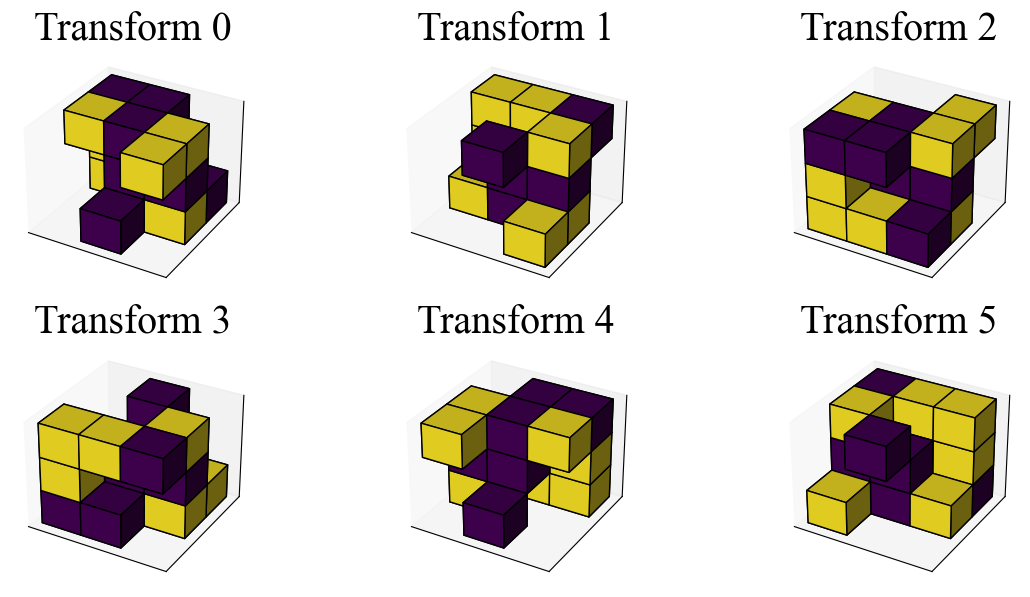

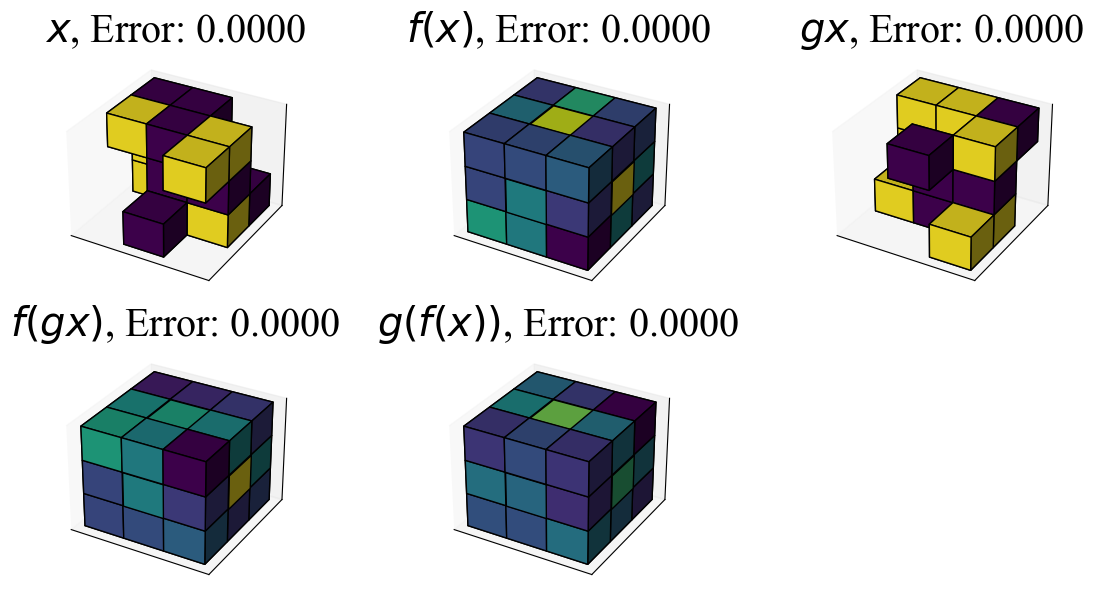

In [56]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 3, # number of classifications, in tic tac toe case, 3
                           kernel_size = n, # 5 originally
                           hidden_dim = 3,
                           dimension = d,
                           num_gconvs = 10)

test_equiv_number = 6 # number of symmetries to test equivariance with, induct on several

print(f"We plot equivariance errors for {test_equiv_number} symmetries of {len(symmetries)} in B({d}) \n")
test_equivariance(GCNN, test_equiv_number, True) ## APPLY INVERSE SYMMETRY IN THIS TO CHECK CONTRAVARIANCE

In [57]:
# MLPs

class RegressionTicTacToeModel(nn.Module): # basic, regression
    def __init__(self):
        super(RegressionTicTacToeModel, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(n**d, 3)  # 27 = 3*3*3, the number of inputs
        
    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        return x
    
class TicTacToeModel(nn.Module): # larger, Lenet 300-100 model
    def __init__(self):
        super(TicTacToeModel, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(n**d, 300)  # 27 = 3*3*3, the number of inputs
        self.linear2 = nn.Linear(300, 100)  # Output classes are -1, 0, 1
        self.linear3 = nn.Linear(100, 3)  # Output classes are -1, 0, 1
        self.output = nn.Softmax(3)
        
    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        return x

## Training

In [58]:
SEED = 0

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

loss_fun = nn.CrossEntropyLoss()

def train_classifier(model, train_loader, valid_loader, learning_rate = 1e-2, num_epoch = 100):
    """
    Train a classification model with a dataset and given hyperparameters.
    """
    print("number of paramters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []
    for epoch in range(1, num_epoch+1):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs[:, None] # remove for mnist
            outputs = model(inputs)
            predictions = outputs.argmax(dim=-1)
            #print("inputs: ", inputs.shape)
            #print("outputs: ", outputs.shape)
            loss = loss_fun(outputs, labels)
            running_loss += loss.item()
            #labels = labels - 1  # Shift labels from {0, 1, 2} (cross entropy) to {-1, 0, 1}

            # non-linear optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # calculate metrics
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        train_loss.append(running_loss / len(dataloader))
        train_acc.append(correct / total)

        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        for inputs, labels in valid_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs[:, None] # remove for mnist
            outputs = model(inputs)
            predictions = outputs.argmax(dim=-1)
            loss = loss_fun(outputs, labels)
            val_running_loss += loss.item()

            val_total += labels.size(0)
            val_correct += (predictions == labels).sum().item()
        
        val_loss.append(val_running_loss / len(valid_loader))
        val_acc.append(val_correct / val_total)

        print(f"Epoch {epoch} | Train Accuracy: {np.mean(train_acc)} | Validation Accuracy: {np.mean(val_acc)}")

    plt.figure(figsize=(10, 6))

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    
    plt.plot(train_loss, label='Training Loss', linewidth=2)
    plt.plot(val_loss, label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Loss', fontsize=24)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)

    plt.legend(fontsize=20)

    plt.grid(True)

    plt.show()

    plt.figure(figsize=(10, 6))

    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    
    plt.plot(train_acc, label='Training Accuracy', linewidth=2)
    plt.plot(val_acc, label='Validation Accuracy', linewidth=2)

    plt.title('Training and Validation Accuracy', fontsize=24)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)

    plt.legend(fontsize=20)

    plt.grid(True)

    plt.show()

### Equivariant network training:

In [59]:
GCNN = GroupEquivariantCNN(in_channels = 1,
                           out_channels = 3, # number of classifications, in tic tac toe case, 3
                           kernel_size = n, # tensor side-length, n
                           hidden_dim = 6,
                           dimension = d, # dimension, d
                           num_gconvs = 2,
                           classifier = True)

train_classifier(GCNN, dataloader, val_dataloader, learning_rate = 2e-2, num_epoch = 100)
# LACK OF CONVERGENCE MEANS DATA IS NOT GOOD ENOUGH, GOOD PRACTICE TO INCREASE DATA SIZE TO N & D
# Used to reach 98+% quickly? Don't know if data is loading incorrectly
# Higher validation than training -> generalization from equi/contravariance...
# use time library (timed on CPU) for runtime tests

number of paramters: 23490
Epoch 1 | Train Accuracy: 0.5481481481481482 | Validation Accuracy: 0.5333333333333333
Epoch 2 | Train Accuracy: 0.5925925925925926 | Validation Accuracy: 0.6333333333333333
Epoch 3 | Train Accuracy: 0.6308641975308641 | Validation Accuracy: 0.6555555555555556
Epoch 4 | Train Accuracy: 0.6587962962962962 | Validation Accuracy: 0.6875
Epoch 5 | Train Accuracy: 0.6803703703703703 | Validation Accuracy: 0.72
Epoch 6 | Train Accuracy: 0.7104938271604938 | Validation Accuracy: 0.7138888888888889
Epoch 7 | Train Accuracy: 0.7145502645502645 | Validation Accuracy: 0.7238095238095238
Epoch 8 | Train Accuracy: 0.725925925925926 | Validation Accuracy: 0.75
Epoch 9 | Train Accuracy: 0.744238683127572 | Validation Accuracy: 0.7703703703703704
Epoch 10 | Train Accuracy: 0.7577777777777779 | Validation Accuracy: 0.7883333333333333
Epoch 11 | Train Accuracy: 0.7757575757575758 | Validation Accuracy: 0.8045454545454546
Epoch 12 | Train Accuracy: 0.7893518518518517 | Validati

KeyboardInterrupt: 

### Vanilla MLP training:

number of paramters: 38803
Epoch 1 | Train Accuracy: 0.6351851851851852 | Validation Accuracy: 0.7166666666666667
Epoch 2 | Train Accuracy: 0.7064814814814815 | Validation Accuracy: 0.725
Epoch 3 | Train Accuracy: 0.7401234567901235 | Validation Accuracy: 0.7333333333333334
Epoch 4 | Train Accuracy: 0.7606481481481482 | Validation Accuracy: 0.7333333333333334
Epoch 5 | Train Accuracy: 0.7781481481481481 | Validation Accuracy: 0.7300000000000001
Epoch 6 | Train Accuracy: 0.79320987654321 | Validation Accuracy: 0.7361111111111112
Epoch 7 | Train Accuracy: 0.8060846560846561 | Validation Accuracy: 0.7380952380952381
Epoch 8 | Train Accuracy: 0.81875 | Validation Accuracy: 0.74375
Epoch 9 | Train Accuracy: 0.8331275720164609 | Validation Accuracy: 0.7462962962962963
Epoch 10 | Train Accuracy: 0.8459259259259259 | Validation Accuracy: 0.7433333333333334
Epoch 11 | Train Accuracy: 0.858080808080808 | Validation Accuracy: 0.746969696969697
Epoch 12 | Train Accuracy: 0.8685185185185184 | Valid

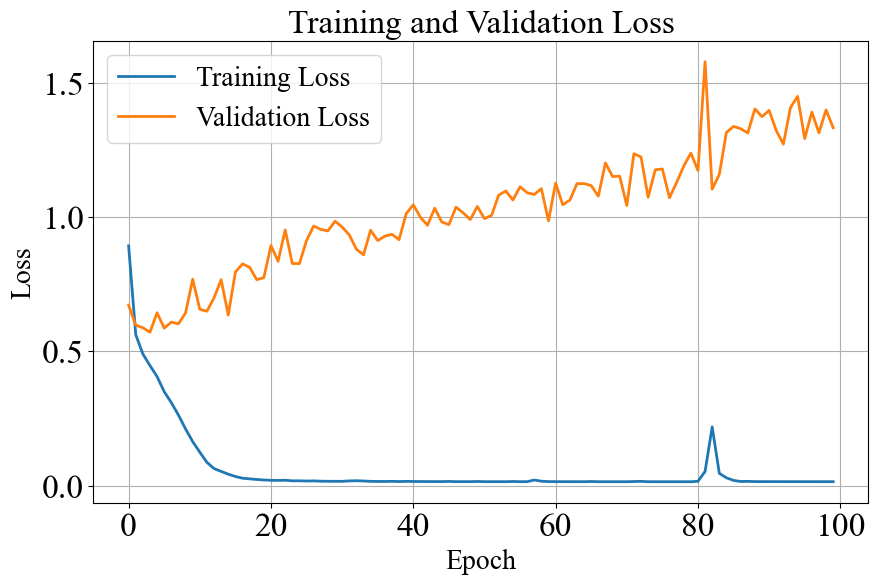

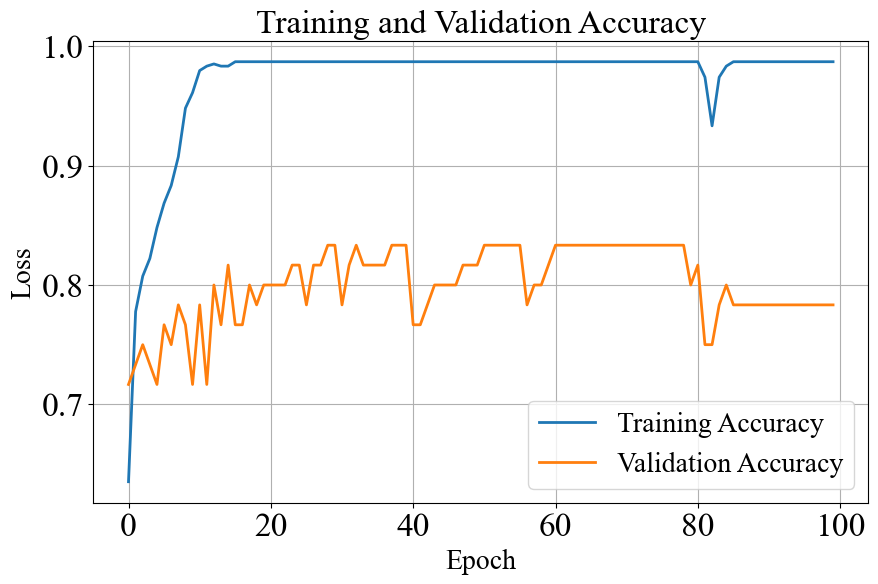

In [61]:
#MLP = RegressionTicTacToeModel() # train and evaluate standard MLP
MLP = TicTacToeModel() # train and evaluate standard MLP

train_classifier(MLP, dataloader, val_dataloader, learning_rate = 1e-3, num_epoch = 100)

### Vanilla MLP (data augmentation) training:

Training dataset size: 540 || # of symmetries for 3-cube: 48 || Augmented training dataset size: 25920
Training dataset size: 60 || # of symmetries for 3-cube: 48 || Augmented training dataset size: 2880
Datasets loaded || 90.0% training to 10.0% validation
number of paramters: 38803
Epoch 1 | Train Accuracy: 0.6240740740740741 | Validation Accuracy: 0.7
Epoch 2 | Train Accuracy: 0.7101851851851853 | Validation Accuracy: 0.725
Epoch 3 | Train Accuracy: 0.7407407407407408 | Validation Accuracy: 0.7277777777777777
Epoch 4 | Train Accuracy: 0.762962962962963 | Validation Accuracy: 0.7291666666666666
Epoch 5 | Train Accuracy: 0.7822222222222222 | Validation Accuracy: 0.73
Epoch 6 | Train Accuracy: 0.7978395061728395 | Validation Accuracy: 0.7277777777777777
Epoch 7 | Train Accuracy: 0.8116402116402117 | Validation Accuracy: 0.7309523809523809
Epoch 8 | Train Accuracy: 0.8277777777777777 | Validation Accuracy: 0.7291666666666667
Epoch 9 | Train Accuracy: 0.8407407407407407 | Validation Accu

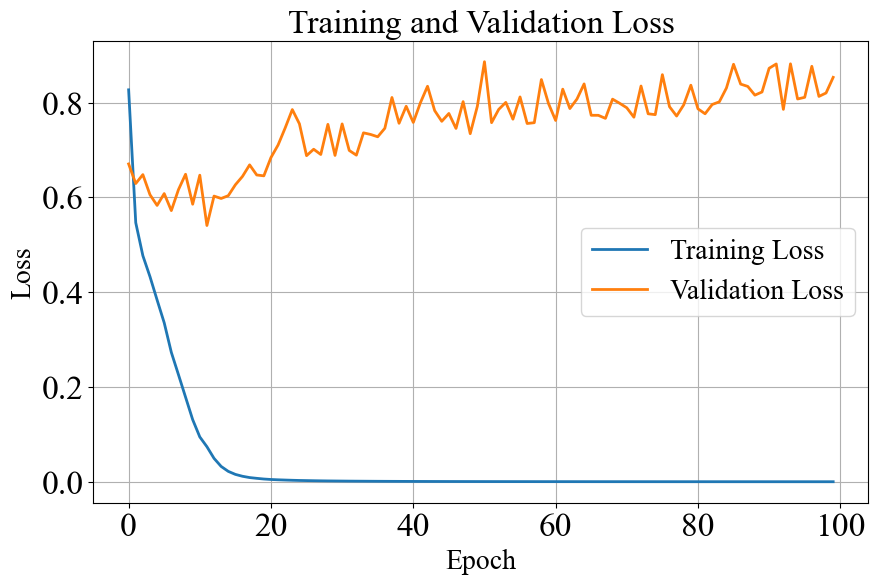

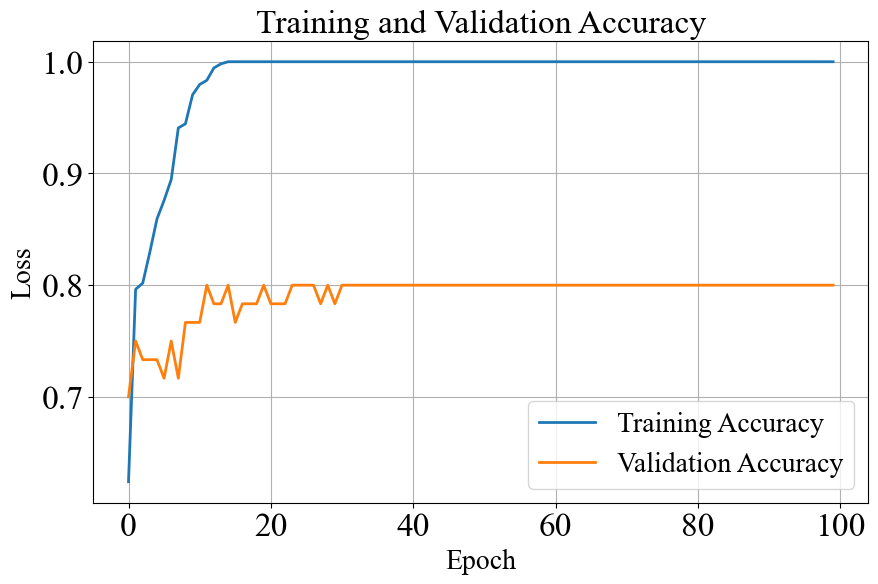

In [62]:
def apply_symmetry(tensor, i): # no batch and channel considerations, just for this
    perm, flips = symmetries[i]
    tensor = tensor.permute(perm)
    for axis, flip in enumerate(flips):
        if flip:
            tensor = torch.flip(tensor, [axis])
    return tensor

augmented_train_dataset = [(apply_symmetry(tensor, i), winner) for i in range(len(symmetries)) for tensor, winner in dataset_train]
augmented_val_dataset = [(apply_symmetry(tensor, i), winner) for i in range(len(symmetries)) for tensor, winner in dataset_val]
# we don't augment test because we want to measure standardized performance across models

print(f"Training dataset size: {len(dataset_train)} || # of symmetries for {d}-cube: {len(symmetries)} || Augmented training dataset size: {len(augmented_train_dataset)}")
print(f"Training dataset size: {len(dataset_val)} || # of symmetries for {d}-cube: {len(symmetries)} || Augmented training dataset size: {len(augmented_val_dataset)}")

#augmented_train_dataset = 
augmented_inputs = torch.stack([item[0] for item in augmented_train_dataset])  # Stack all game boards
augmented_labels = torch.tensor([item[1] for item in augmented_train_dataset])  # List of winners
augmented_labels = labels.long() + 1 # Convert labels to 0, 1, 2 for CrossEntropyLoss

batch_size = 16
# Optional: Create DataLoader for batching
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

augmented_val_inputs = torch.stack([item[0] for item in augmented_val_dataset])  # Stack all game boards from the validation dataset
augmented_val_labels = torch.tensor([item[1] for item in augmented_val_dataset])  # List of winners from the validation dataset
augmented_val_labels = val_labels.long() + 1  # Convert labels for CrossEntropyLoss, adjusting from -1,0,1 to 0,1,2

augmented_val_dataset = TensorDataset(val_inputs, val_labels)
augmented_val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

augmented_test_inputs = torch.stack([item[0] for item in dataset_test])
augmented_test_labels = torch.tensor([item[1] for item in dataset_test])
augmented_test_labels = test_labels.long() + 1

augmented_test_dataset = TensorDataset(test_inputs, test_labels)
augmented_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_and_validation_size = augmented_labels.size(0) + augmented_val_labels.size(0)
print(f"Datasets loaded || {round(100*labels.size(0) / train_and_validation_size, 3)}% training to {round(100*val_labels.size(0) / train_and_validation_size, 3)}% validation")

#MLP2 = RegressionTicTacToeModel()
MLP2 = TicTacToeModel()
train_classifier(MLP2, dataloader, val_dataloader, learning_rate = 1e-3, num_epoch = 100)

## Evaluation

In [63]:
def evaluate_model(model, data_loader, loss_function, plot = False):
    """
    Run evaluation batches from the testing dataset and calculate average accuracy over each batch.
    """
    model.eval()  # Set the model to evaluation mode
    test_acc = []
    test_loss = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs = inputs[:, None]  # Adjust input dimensions if necessary
            outputs = model(inputs)
            pred = outputs.argmax(dim=-1)
            loss = loss_function(outputs, labels)

            test_loss.append(loss.item())  # Get the scalar value of the loss
            correct_predictions = (pred == labels).sum().item()
            total_samples = labels.size(0)
            acc = correct_predictions / total_samples
            test_acc.append(acc)

    avg_acc = np.mean(test_acc)
    avg_loss = np.mean(test_loss)

    if plot:
        # loss
        plt.figure(figsize=(10, 6))

        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 24

        plt.plot(test_loss, label='Test Loss', linewidth=2)
        plt.plot([avg_loss] * len(test_loss), label='Average Loss', color = "red", linewidth=2)
        plt.title(f'Test Loss ({round(avg_loss, 3)} average)', fontsize=24)
        plt.xlabel('Epoch', fontsize=20)
        plt.ylabel('Loss', fontsize=20)

        plt.legend(fontsize=20)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # accuracy
        plt.figure(figsize=(10, 6))

        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 24

        plt.plot(test_acc, label='Test Accuracy', linewidth=2)
        plt.plot([avg_acc] * len(test_acc), label='Average Loss', color = "red", linewidth=2)
        plt.title(f'Test Accuracy ({round(avg_acc, 3)} average)', fontsize=22)
        plt.xlabel('Epoch', fontsize=20)
        plt.ylabel('Accuracy', fontsize=20)

        plt.legend(fontsize=20)

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return avg_loss, avg_acc


### Equivariant network evaluation:

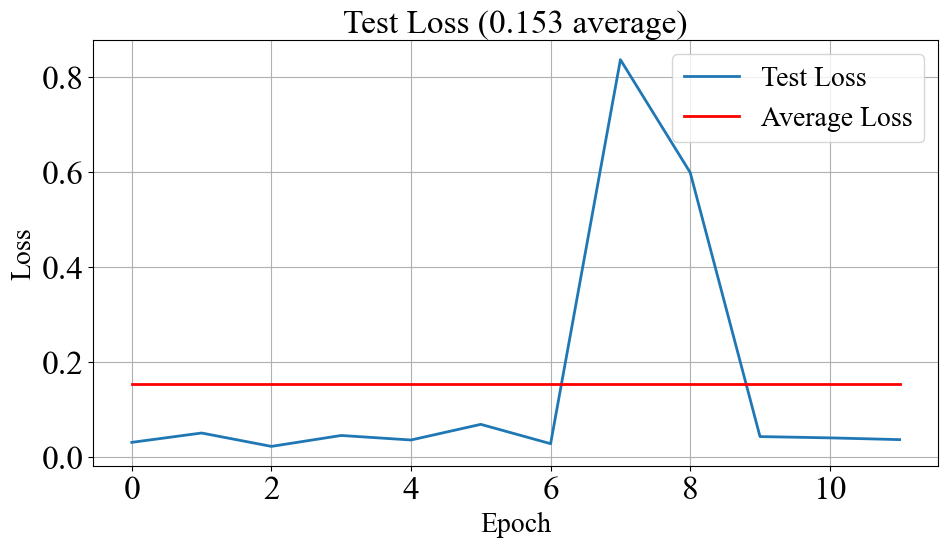

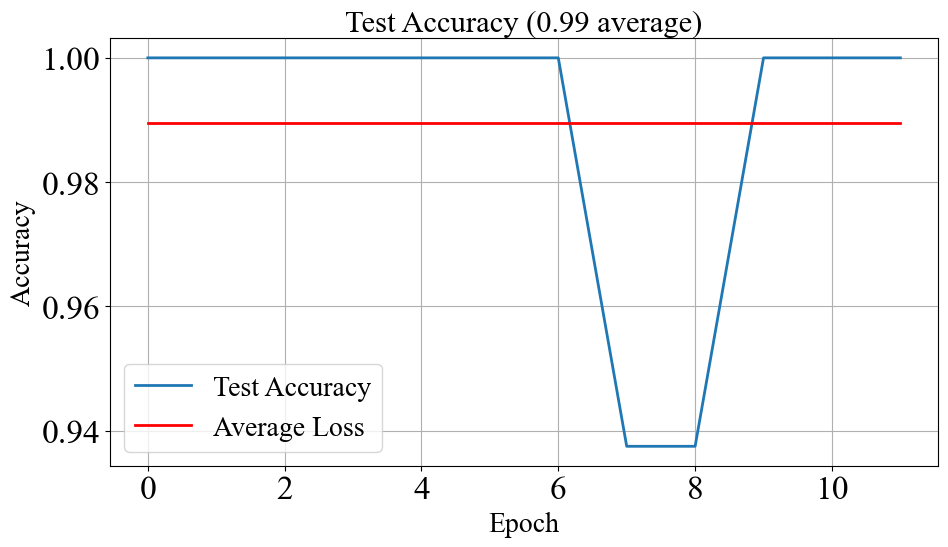

Test Loss: 0.1526, Test Accuracy: 0.9896


In [64]:
avg_loss, avg_acc = evaluate_model(GCNN, test_dataloader, loss_fun, plot = True)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")

### Vanilla MLP evaluation:

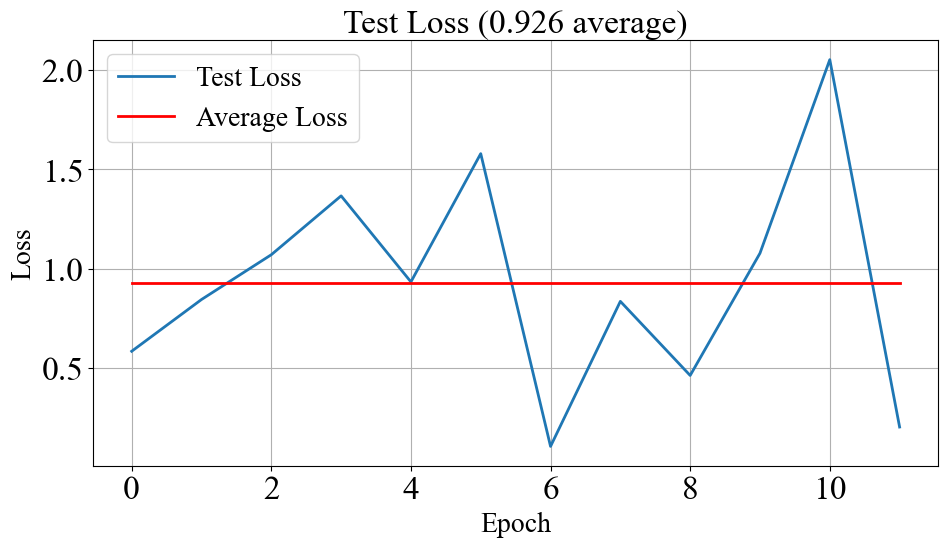

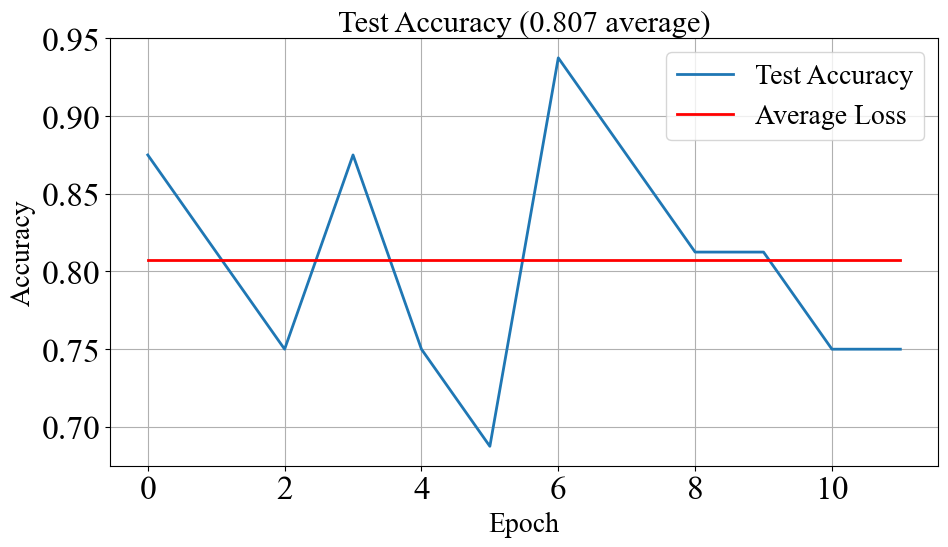

Test Loss: 0.9256, Test Accuracy: 0.8073


In [66]:
avg_loss, avg_acc = evaluate_model(MLP, test_dataloader, loss_fun, plot = True)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")

### Vanilla MLP (with data augmentation) evaluation:

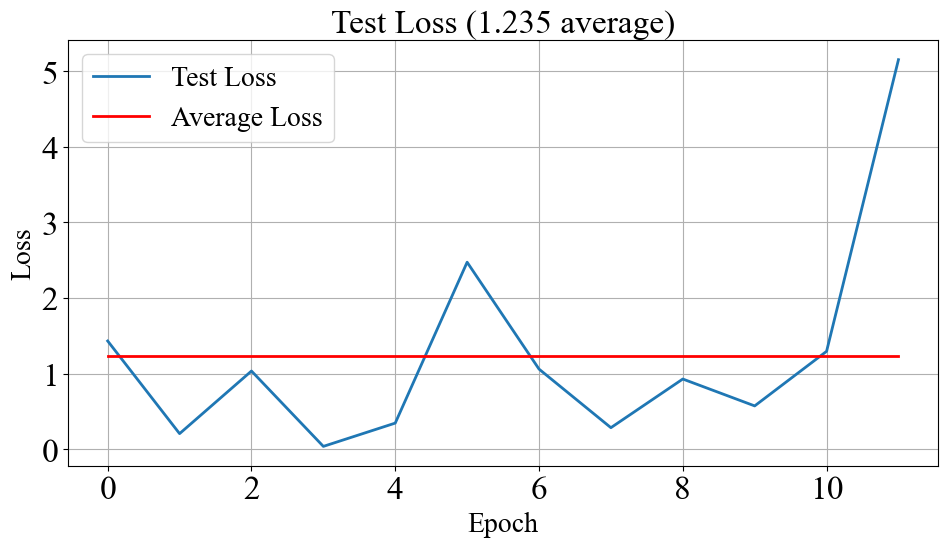

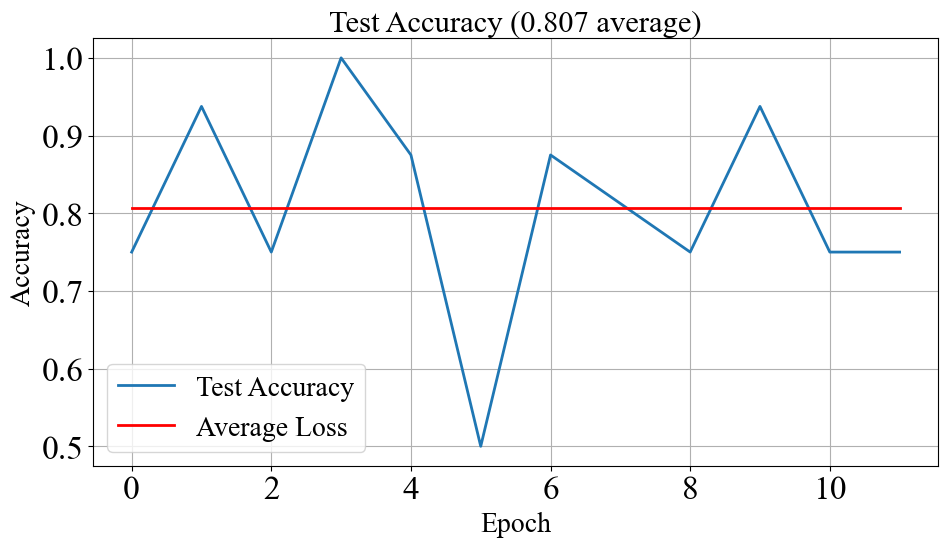

Test Loss: 1.2350, Test Accuracy: 0.8073


In [67]:
avg_loss, avg_acc = evaluate_model(MLP, test_dataloader, loss_fun, plot = True)
print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")